<a href="https://colab.research.google.com/github/DanielIramain/aa-unahur/blob/main/insurance_aa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generar Data Frame

Previa conexion a Mi Drive:
- A partir del set de datos insurance_aa_2023.csv generar el data frame "data".

EL objetivo de este trabajo práctico será predecir el costo médico de personas en EE.UU. utilizando los distintos modelos vistos en el curso. Podrán encontrar más información sobre el dataset [aqui](https://www.kaggle.com/datasets/mirichoi0218/insurance?select=insurance.csv).

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Modulos para imputación, detección y estandarización
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler

# Modulos para regresion lineal con CV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Modulos para arboles de decisión
from sklearn.tree import DecisionTreeRegressor # Arboles de decisión para regresión
from sklearn.tree import plot_tree # Función para visualizar el árbol
from sklearn.ensemble import RandomForestRegressor # Random forests para decisión

# Módulos para evaluar el modelo
from sklearn.model_selection import train_test_split, KFold # Para separar en train y test
from sklearn.model_selection import cross_val_score # Para hacer cross-validation y evaluar el modelo

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/insurance_aa_2023.csv')

In [ ]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Exploración del dataset

1. A partir de los datos entregados, describir los atributos realizando una breve explicación de qué representan y del tipo de variable (categórica, numérica u ordinal). En caso de que haya variables no numéricas, reportar los posibles valores que toman y cuán frecuentemente lo hacen.



*   Ver los primeros seis registros
*   Ver el tamaño del dataset
*   Ver los tipos de datos de cada columna
*   Usar el método describe() para ver las variables numéricas

In [ ]:
# Ver los primeros seis registros
data.head(6)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160


El dataset tiene 7 atributos, los cuales se dividen en:


*   Variables numericas: age (edad), bmi (índice de masa corporal), children (hijos) y charges (cargo o monto, la cual es a su vez la variable target)
*   Variables categoricas: sex (sexo del sujeto), smoker (fumador, una variable dicotómica entre si o no) y region (región a la que pertenece el sujeto).

En principio, no se encuentran variables ordinales (salvo que se agrupe la edad, por ej. niños/adolescentes/adultos).


In [ ]:
# Recuento de valores (tabla de frecuencia) de variables categoricas:
for column in data:
  if data[column].dtype == 'object':
    frecuencia = data[column].value_counts()
    print(frecuencia)
    print('===///===')

male      676
female    662
Name: sex, dtype: int64
===///===
no     1064
yes     274
Name: smoker, dtype: int64
===///===
southeast    361
southwest    321
northeast    321
northwest    317
Name: region, dtype: int64
===///===


In [ ]:
# Ver el tamaño del dataset
dimension = data.shape

print(f'El dataset tiene {dimension[0]} filas y {dimension[1]} columnas')

El dataset tiene 1338 filas y 7 columnas


In [ ]:
# Ver los tipos de datos de cada columna
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1320 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Observamos, además de la clase a la que pertenece el retorno de la función info(), el rango del dataset (1338 entradas comenzando con un índice en 0) así como constatamos que los tipos de datos se corresponden con nuestro análisis previo sobre las variables numéricas (ahora discriminado en discretas y continuas, es decir int y float) y categóricas.

Por otro lado, también tenemos un primer vistazo de datos faltantes, en este caso solo en el atributo correspondiente a la región a la que pertenece el sujeto.

In [ ]:
# Usar el método describe() para ver las variables numéricas
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


El método describe() nos devuelve la media (promedio aritmético simple) de las variables numéricas en cuestión así como su desvío estándar. Por dar un ejemplo, la media del monto (nuestra variable target) es de 13270,42 dólares con un desvío de +/- 12110 dólares (un estadístico considerablemente alto).

Continuando con el ejemplo, el valor mínimo que toma el monto es de 1121,87 dólares y, a su vez, el valor máximo es de 63770,43 dólares. La media (el estadístico que separa el conjunto de datos en dos partes iguales) es de 9382,03 dólares.

Adicionalmente, el mencionado método también nos facilita el rango intercuartilico (75% - 25%).

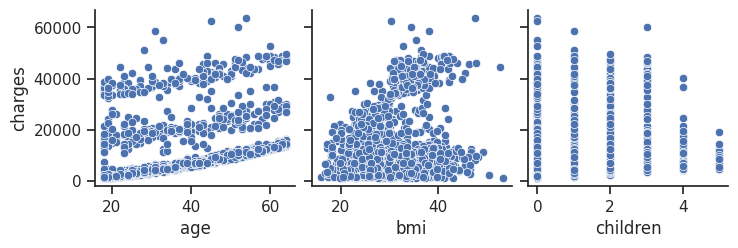

In [ ]:
# Visualización de charges en relación con algunas variables utilizando Seaborn
sns.set(style='ticks')
sns.pairplot(data, x_vars=['age', 'bmi', 'children'], y_vars='charges', kind='scatter')
plt.show()

2. Verificar la existencia de valores faltantes. Si los hay, ¿cuántos son y en qué atributos se encuentran? En caso de haberlos, realice la imputación de los mismos.

In [ ]:
data.isna().sum()

age          0
sex          0
bmi          0
children     0
smoker       0
region      18
charges      0
dtype: int64

Hay 18 datos faltantes en el atributo region. Imputación de los datos: a través de la clase SimpleImputer utilizando como estrategia el valor más frecuente. En este caso trabajaremos solo una columna en lugar de toda la tabla (asignará a cada región faltante la región más frecuente, debido a que es el único atributo donde hay valores faltantes).

In [ ]:
imputer = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
col = data['region'].values.reshape(-1, 1)

imputer = imputer.fit(col)

data['region'] = pd.DataFrame(imputer.transform(col))

In [ ]:
#Volvemos a consultar datos faltantes
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

3. Estandarizar las variables numéricas (con excepción de _charges_ que es la variable a predecir).

4. Usar el metodo _get_dummies()_ para reemplazar las variables categóricas.

Para este punto, primero detectaremos outliers en nuestro conjunto de datos a través de LOF. Para ello, como primer paso, debemos realizar una conversión (codificación) de las variables categoricas, motivo por el cual primero se realizará el punto 4 utilizando un método del módulo pandas.

In [ ]:
data = pd.get_dummies(data, columns=['sex', 'smoker', 'region'], prefix=['sex', 'smoker', 'region'])

In [ ]:
# Veamos como queda nuestro dataset
data

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,0,1,1,0,0,1,0,0
1334,18,31.920,0,2205.98080,1,0,1,0,1,0,0,0
1335,18,36.850,0,1629.83350,1,0,1,0,0,0,1,0
1336,21,25.800,0,2007.94500,1,0,1,0,0,0,0,1


Con los datos codificados, pasaremos a detectar outliers a través de la instanciación del siguiente objeto:

In [ ]:
lof_outlier = LocalOutlierFactor(n_neighbors=10)
outlier_scores = lof_outlier.fit_predict(data)

In [ ]:
# Vemos cuantos datos considerados outliers tenemos
sum(outlier_scores == -1)

42

In [ ]:
# Elimino los outliers de mis datos, es decir, asigno al dataset solo los datos
# considerados "no outliers".
mask = outlier_scores == 1
data = data.loc[mask,:]

Para que las distintas variables numéricas puedan ser comparables entre sí es necesario estandarizarlas. En este caso, con la codificación realizada y los outliers tratados, trabajaremos con el método MinMax.

Este método de normalización garantiza que todos los atributos tengan la misma escala, lo cual aumenta la eficiencia de nuestro modelo, pero (a diferencia de Z-Score) no es robusto ante outliers, motivo por el cual primero los eliminamos de nuestro dataset.

In [ ]:
# Vamos a quedarnos con todas las columnas menos la variable que
# buscamos predecir
col = ['age', 'bmi', 'children']

In [ ]:
min_max_scaler = MinMaxScaler()
data[col] = min_max_scaler.fit_transform(data[col])

In [ ]:
# Exportamos el set de datos estandarizados a CSV
# por si lo necesitamos posteriormente
data.to_csv('data_estandarizada.csv')

## Modelos

5. Dividir el dataset en un conjunto de entrenamiento (90%) y uno de testeo (10%).

In [ ]:
# Definimos las variables
X = data.drop('charges', axis=1)
Y = data['charges']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [ ]:
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento: (1166, 11)
Tamaño del conjunto de prueba: (130, 11)


In [ ]:
# Antes de seguir:
# Verificamos que cada atributo sea del tipo de dato que necesitamos
# para trabajar
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1337
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1296 non-null   float64
 1   bmi               1296 non-null   float64
 2   children          1296 non-null   float64
 3   charges           1296 non-null   float64
 4   sex_female        1296 non-null   uint8  
 5   sex_male          1296 non-null   uint8  
 6   smoker_no         1296 non-null   uint8  
 7   smoker_yes        1296 non-null   uint8  
 8   region_northeast  1296 non-null   uint8  
 9   region_northwest  1296 non-null   uint8  
 10  region_southeast  1296 non-null   uint8  
 11  region_southwest  1296 non-null   uint8  
dtypes: float64(4), uint8(8)
memory usage: 60.8 KB


6. Realizar:

*   Un modelo de regresión lineal.
*   Un modelo de árboles de decisión.
*   Random forest.

En todos los casos elija un hiperparámetro para ajustar utilizando **cross-validation**. ¿Cuáles fueron las variables más importantes para cada uno de los modelos?

In [ ]:
#Definimos los alpha que queremos probar
alphas = np.arange(0.01, 0.99, 0.01)

**Modelos de regresión lineal con validación cruzada**

Modelo con penalización Ridge

In [ ]:
#Modelo Ridge
reg_ridgeCV = RidgeCV(alphas=alphas, cv=5)
reg_ridgeCV.fit(X_train, Y_train)

RidgeCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98]),
        cv=5)

In [ ]:
# Predicciones en el conjuto de entrenamiento para Ridge (para R2)
y_train_pred_ridgeCV = reg_ridgeCV.predict(X_train)

# Predicciones en el conjunto de testeo para Ridge
y_test_pred_ridgeCV = reg_ridgeCV.predict(X_test)

# Cálculo del error cuadrático medio en el conjunto de testeo
mse_ridgeCV = mean_squared_error(Y_test, y_test_pred_ridgeCV)

print("Mejor alpha encontrado:", reg_ridgeCV.alpha_)
print("Error cuadrático medio (RidgeCV):", mse_ridgeCV)

Mejor alpha encontrado: 0.98
Error cuadrático medio (RidgeCV): 28176220.385337707


Modelo con penalización Lasso

In [ ]:
#Modelo Lasso
reg_lassoCV = LassoCV(alphas=alphas, cv=5)
reg_lassoCV.fit(X_train, Y_train)

LassoCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98]),
        cv=5)

In [ ]:
# Predicciones en el conjunto de entrenamiento para Lasso (para R2)
y_train_pred_lassoCV = reg_lassoCV.predict(X_train)

# Predicciones en el conjunto de testeo para Lasso
y_test_pred_lassoCV = reg_lassoCV.predict(X_test)

# Cálculo del error cuadrático medio en el conjunto de testeo
mse_lassoCV = mean_squared_error(Y_test, y_test_pred_lassoCV)

print("Mejor alpha encontrado:", reg_lassoCV.alpha_)
print("Error cuadrático medio (LassoCV):", mse_lassoCV)

Mejor alpha encontrado: 0.98
Error cuadrático medio (LassoCV): 28172073.014860597


In [ ]:
r2_score(Y_train, y_train_pred_ridgeCV)

0.7481084884455105

In [ ]:
r2_score(Y_test, y_test_pred_ridgeCV)

0.7957207300949576

In [ ]:
r2_score(Y_train, y_train_pred_lassoCV)

0.748144203787106

In [ ]:
r2_score(Y_test, y_test_pred_lassoCV)

0.7957507987770414

Cuando calculamos R2 en el conjunto de entrenamiento, el valor nos indica cuanto de la varianza presente en la muestra es explicada por nuestro modelo, mientras que calcularlo en el conjunto de testeo nos indica la "calidad predictiva" del mismo.

Puede darse, como en este caso, un R2 más alto en testeo que en entrenamiento. Si la diferencia es relativamente grande, probablemente el modelo "underfittea" (puede llegar a darse en conjuntos con pocos datos como este). Dicha diferencia también puede significar que se está previiendo el overfitting en el modelo.

Cabe destacar, por otro lado, que el calculo del R2 en los datos de entrenamiento suele ser desestimado debido a que entra en juego la influencia de la divisón de los datos (en este caso 90% y 10% respectivamente), por lo que estas conclusiones son relevantes solo en principio.


**Modelo de árbol de decisión** 🌳

In [ ]:
# Lista de features (variables) que vamos a considerar
features = ['age', 'bmi', 'children', 'sex_female', 'sex_male', 'smoker_no', 'smoker_yes',
            'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']

# Variable a predecir
target = 'charges'

# Construcción de la matriz de features (variables X)
# (scikit-learn necesita un formato matricial, no df, por ello usamos el método)
X = data[features].to_numpy()

# Construcción del vector a predecir (variable Y)
y = data[target].to_numpy()

print('Dimensión de la matriz de features: {}'.format(X.shape))
print('Dimensión del vector a predecir: {}'.format(y.shape))
print('Vector a predecir: {}'.format(y))

Dimensión de la matriz de features: (1296, 11)
Dimensión del vector a predecir: (1296,)
Vector a predecir: [16884.924   1725.5523  4449.462  ...  1629.8335  2007.945  29141.3603]


In [ ]:
# Tomamos un valor de alpha entre 10^-10 y 1. Usamos un barrido logaritmico.
for alpha in np.logspace(-10, 0, 11):

    # Creamos el modelo para un dado valor de alpha
    dtr = DecisionTreeRegressor(ccp_alpha = alpha)

    # Calculamos los scores al hacer cross-validation con 5 folds
    scores = cross_val_score(dtr, X_train, Y_train, cv = 5)

    # Imprimimos el valor de alpha y el score medio
    print('Valor de alpha {} - Score medio = {}'.format(alpha, scores.mean()))

Valor de alpha 1e-10 - Score medio = 0.6915477492720019
Valor de alpha 1e-09 - Score medio = 0.6808116532397553
Valor de alpha 1e-08 - Score medio = 0.6986709457161385
Valor de alpha 1e-07 - Score medio = 0.698713551762489
Valor de alpha 1e-06 - Score medio = 0.69756255474297
Valor de alpha 1e-05 - Score medio = 0.6873891738028676
Valor de alpha 0.0001 - Score medio = 0.6838244681929149
Valor de alpha 0.001 - Score medio = 0.6972874841146106
Valor de alpha 0.01 - Score medio = 0.6978382031345258
Valor de alpha 0.1 - Score medio = 0.6927529380321197
Valor de alpha 1.0 - Score medio = 0.6840456544253412


Más o menos vemos que con un valor de $\alpha = 1e-09$ (variable)  tenemos un buen score y sabemos que nos previene de hacer overfitting. Vemos a qué profundidad de árbol corresponde y qué tan bien le va en el set de testeo:

In [ ]:
# Creación del modelo con regularización óptima
dtr = DecisionTreeRegressor(ccp_alpha = 10**-9)

# Entrenamiento
dtr.fit(X_train, Y_train)

# Profundidad del árbol al entrenarlo regularizado
depth = dtr.get_depth() # Con este método vemos la profundidad
print('Profundidad del arbol = {}'.format(depth))

# Score en el set de entrenamiento
score_in_train = dtr.score(X_train, Y_train)
print('Score en el set de entrenamiento: {}'.format(score_in_train))

# Score en el set de testeo
score_in_test = dtr.score(X_test, Y_test)
print('Score en el set de testeo: {}'.format(score_in_test))

Profundidad del arbol = 19
Score en el set de entrenamiento: 0.9995164302784219
Score en el set de testeo: 0.8093422639216186


Mientras que el score en el conjunto de entrenamiento es prácticamente perfecto, en testeo es notablemente más bajo. Eso es un claro indicio de overfitting. Para evitarlo podemos variar la profundidad del árbol, fijar el número de hojas, hacer crecer el árbol de forma tal de que siempre haya un mínimo de instancias, etc.

En las siguientes celdas, antes de pasar al modelo con algoritmo de Random Forest, se propone una solución utilizando un mínimo de muestra por cada hoja (hiperparámetro elegido subjetivamente).

In [ ]:
# Creación del modelo con regularización óptima
dtr = DecisionTreeRegressor(ccp_alpha = 10**-9, min_samples_leaf=150)

# Entrenamiento
dtr.fit(X_train, Y_train)

# Profundidad del árbol al entrenarlo regularizado
depth = dtr.get_depth() # Con este método vemos la profundidad
print('Profundidad del arbol = {}'.format(depth))

# Score en el set de entrenamiento
score_in_train = dtr.score(X_train, Y_train)
print('Score en el set de entrenamiento: {}'.format(score_in_train))

# Score en el set de testeo
score_in_test = dtr.score(X_test, Y_test)
print('Score en el set de testeo: {}'.format(score_in_test))

Profundidad del arbol = 4
Score en el set de entrenamiento: 0.699538505134973
Score en el set de testeo: 0.734668849114299


[Text(0.4444444444444444, 0.9, 'smoker_no <= 0.5\nsquared_error = 138585218.346\nsamples = 1166\nvalue = 13174.697'),
 Text(0.3333333333333333, 0.7, 'squared_error = 116880406.882\nsamples = 231\nvalue = 31812.616'),
 Text(0.5555555555555556, 0.7, 'age <= 0.62\nsquared_error = 36923348.069\nsamples = 935\nvalue = 8570.035'),
 Text(0.3333333333333333, 0.5, 'age <= 0.315\nsquared_error = 23865110.14\nsamples = 595\nvalue = 6010.319'),
 Text(0.2222222222222222, 0.3, 'children <= 0.1\nsquared_error = 27141278.644\nsamples = 341\nvalue = 4752.201'),
 Text(0.1111111111111111, 0.1, 'squared_error = 17633171.382\nsamples = 177\nvalue = 3481.309'),
 Text(0.3333333333333333, 0.1, 'squared_error = 33778499.094\nsamples = 164\nvalue = 6123.835'),
 Text(0.4444444444444444, 0.3, 'squared_error = 14488887.403\nsamples = 254\nvalue = 7699.366'),
 Text(0.7777777777777778, 0.5, 'age <= 0.793\nsquared_error = 28243052.351\nsamples = 340\nvalue = 13049.539'),
 Text(0.6666666666666666, 0.3, 'squared_error 

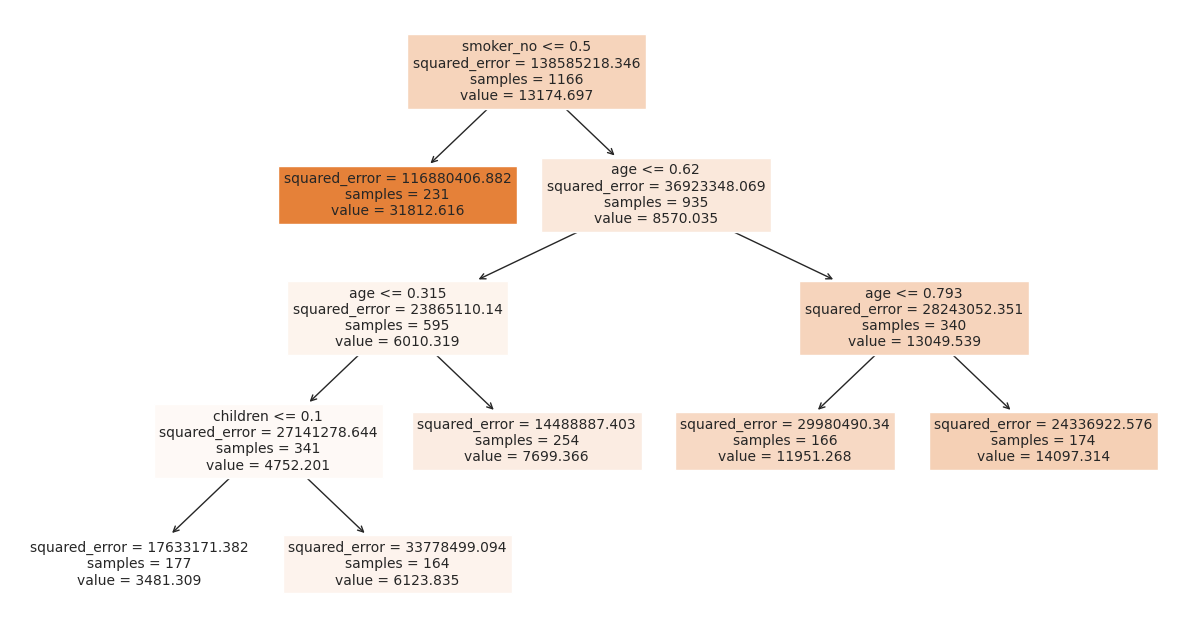

In [ ]:
# Creamos la figura donde plotear el árbol con matplotlib
fig, ax = plt.subplots(figsize = (15, 8))

# Llamamos a la función "plot_tree" que importamos de sklearn.tree más arriba.
# Le pasamos como argumento el modelo que creamos y el nombre de los features.
# "fontsize" y "filled" son solo ajustes de la visualización
# y le decimos que plotee el arbol en la figura que creamos
plot_tree(dtr, feature_names=features, fontsize = 10, filled = True, ax = ax)

🌳🌳🌳 **Modelo de Random Forest (ensamble)** 🌳🌳🌳

In [ ]:
# Constuimos el modelo de Random Forest con 100 estimadores
# Por default, cada árbol individual es entrenado hasta máxima profundidad
rfr = RandomForestRegressor(n_estimators=100)

In [ ]:
# Entrenamiento del modelo
rfr.fit(X_train, Y_train)

RandomForestRegressor()

In [ ]:
# Score en el set de entrenamiento
score_in_train = rfr.score(X_train, Y_train)
print('Score en el set de entrenamiento: {}'.format(score_in_train))

# Score en el set de testeo
score_in_test = rfr.score(X_test, Y_test)
print('Score en el set de testeo: {}'.format(score_in_test))

Score en el set de entrenamiento: 0.9758825767037004
Score en el set de testeo: 0.8969748107455762


Nuevamente notamos overfitting en el desarrollo de este modelo al comparar sus scores en entrenamiento y testeo respectivamente.

In [ ]:
# Constuimos el modelo de Random Forest con 100 estimadores
# Pero ahora agregamos un hiperparametro (minimo de muestras)
# Por default, cada árbol individual es entrenado hasta máxima profundidad
rfr = RandomForestRegressor(n_estimators=100, min_samples_leaf=100)

In [ ]:
# Volvemos a entrenar el modelo
rfr.fit(X_train, Y_train)

RandomForestRegressor(min_samples_leaf=100)

In [ ]:
# Score en el set de entrenamiento
score_in_train = rfr.score(X_train, Y_train)
print('Score en el set de entrenamiento: {}'.format(score_in_train))

# Score en el set de testeo
score_in_test = rfr.score(X_test, Y_test)
print('Score en el set de testeo: {}'.format(score_in_test))

Score en el set de entrenamiento: 0.7020660661320579
Score en el set de testeo: 0.7376588842100731


Si bien los scores se han reducido notablemente, ahora contamos con una estimación más realista (evitando el overfitting) al trabajar con un hiperparametro.

In [ ]:
# Este atributo tiene una medida de la importancia de cada feature
feature_importance = rfr.feature_importances_

print('Features: {}'.format(features))
print('Importancia = {}'.format(feature_importance))

# Comprobación de la medida de importancia (deben sumar 1)
sum(feature_importance)

Features: ['age', 'bmi', 'children', 'sex_female', 'sex_male', 'smoker_no', 'smoker_yes', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
Importancia = [0.13161248 0.19721135 0.02215827 0.00343909 0.00385242 0.39192652
 0.23068082 0.00556323 0.0045335  0.0052218  0.00380052]


1.0

Como puede observarse en el peso de cada atributo (se analizó a partir del primer random forest desarrollado, para no reconvertir los valores entregados en la estructura de datos de tipo lista), los tres que resultaron más relevantes en los modelos son el hecho de si se es (o no) fumador, el índice de masa corporal (bmi) y la edad respectivamente.

7. Mencione la forma en la que se controló el overfitting en cada uno de los modelos realizados en el punto anterior.

El overfitting (y underfitting) hace referencia al fallo de nuestro modelo al generalizar -encajar- el conocimiento que pretendemos que adquieran, es uno de los principales inconvenientes al resolver problemas de AA.

El overfitting particularmente falla en reconocer un nuevo dato porque no tiene estrictamente los mismos valores de las muestras de entrenamiento.

En los modelos de regresión lineal se controló a través de la utilización de penalizaciones (Lasso y Ridge) con validación cruzada de 5 "folios", lo cual permitió obtener, posteriormente, R2 que fueron comparados en su respectivo apartado.

Por otro lado, en los modelos de árboles de decisión (incluido el algoritmo de Random Forest) el overfitting fue mucho más notable al comparar los scores de los conjuntos de datos de entrenamiento contra los de testeo. En ambos casos, se procedió a ajustar los modelos utilizando hiperparámetros, particularmente el que obliga al modelo a tener una cantidad mínima de muestras por hoja, lo que llevó a reducir su score pero también a tener una mejor calidad predictiva (aunque baja).

8. Compare los modelos realizados. ¿Cuál considera que obtuvo un mejor resultado?

Nuestro modelo de Regresión Lineal con penalización Lasso fue el que obtuvo el mejor score de testeo (R2 = 0.7950...), volviendolo el mejor candidato para este problema de AA supervisado. Por otro lado, cabe destacar, que hay otras métricas para evaluar el desempeño del modelo, siendo el R2 del conjunto de testeo el que nos da un indicio de "qué tan bien" predeciría  nuestro modelo en una situación normal.

Así mismo, también debe notarse que no hay mayores diferencias entre la penalización Lasso y Ridge, posiblemente explicado por el preprocesamiento de los datos junto con la separación del conjunto total de datos (90% entrenamiento y 10% testeo). Se debe recordar, así mismo, que Ridge no penaliza llevando atributos a 0 (quitándoles totalmente su importancia).

Esta comparación fue posible ya que, siguiendo la documentación del modulo Scikit-learn, los scores arrojados por los modelos de árboles de decisión ya están expresados en términos de representativad (R2).